##### 基礎演習 (30分)
* 畳み込み層 (L.Convolution2D)
* パディング・ストライドの指定 (pad, stride)
* プーリング層 (F.max\_pooling, F.avg\_pooling)
* 画像の入力
* 小課題：畳み込み・プーリングを使ってみる (使い方の学習)
* 小課題：パラメータ数の計算と比較
* Variableの形状変換 (F.flatten())

# Import

chainerを使ってコードを書くときによく使うものをまとめてimportしておきます

(Chainer Turorial推奨: https://docs.chainer.org/en/stable/tutorial/basic.html#core-concept 参照)

In [26]:
!pip install chainer

In [0]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

# L.Convolution2D

2次元カーネルの畳み込み層は、chainerでは
```python
L.Convolution2D
```
を使います。

https://docs.chainer.org/en/stable/reference/generated/chainer.links.Convolution2D.html

（講義スライドでは3次元とか4次元とか書いてありますが、「フィルタ」は2次元なので、ここではConvolution2Dです）

`L.Convolution2D` の作用を確かめてみましょう。

(1, 1, 3, 3)次元の入力マップxに、(1, 1, 2, 2)次元のフィルタを畳み込んでみます。

講義スライドでは、「3次元入力に4次元フィルタを畳み込む」と書きましたが、
複数枚の画像をまとめて入力するため、Convolution2Dは4次元配列を入力に取るようになっています

In [0]:
x_data = np.array([[[
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
]]], dtype=np.float32)
x = Variable(x_data)

In [0]:
conv = L.Convolution2D(
    in_channels=1, out_channels=1, ksize=2, stride=1, pad=0,
    initialW=np.array([[[
        [1, 2],
        [3, 4],
    ]]]),
    initial_bias=np.array([0])
)

In [31]:
conv(x)

variable([[[[37., 47.],
            [67., 77.]]]])

手で計算してみて、結果を見比べてみると分かりやすいかもしれません

例えば、[0,0]は `1*1 + 2*2 + 3*4 + 4*5 = 37` になっています

# 画像入力

## ダウンロード

In [3]:
!wget http://livedoor.blogimg.jp/klab_tech/imgs/4/c/4ced895f.png -O lena_color.png
!wget https://raw.githubusercontent.com/wbap/NICO2AI_Pilot/master/lecture7/lena_gray.gif -O lena_gray.png

--2018-02-17 05:34:02--  https://raw.githubusercontent.com/wbap/NICO2AI_Pilot/master/lecture7/lena_color.gif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227335 (222K) [image/gif]
Saving to: ‘lena_color.png’

lena_color.png      100%[===================>] 222.01K  --.-KB/s    in 0.05s   

2018-02-17 05:34:02 (4.15 MB/s) - ‘lena_color.png’ saved [227335/227335]

--2018-02-17 05:34:03--  https://raw.githubusercontent.com/wbap/NICO2AI_Pilot/master/lecture7/lena_gray.gif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264598 (258K) [image/gi

## 画像読み込み

In [0]:
from skimage.io import imread
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
lena = imread('./lena_gray.png')

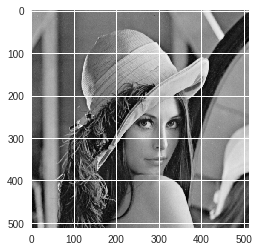

In [35]:
plt.imshow(lena, cmap='gray')

画像はピクセルの配列です。

In [36]:
lena

array([[162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       ...,
       [ 43,  43,  50, ..., 104, 100,  98],
       [ 44,  44,  55, ..., 104, 105, 108],
       [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8)

In [37]:
lena.shape

(512, 512)

エッジ検出フィルタを畳み込んでみます

In [0]:
vertical_edge = L.Convolution2D(
    in_channels=1, out_channels=1, ksize=3, stride=1, pad=0,
    initialW=np.array([[[
        [0, 0, 0],
        [-0.5, 0, 0.5],
        [0, 0, 0]
    ]]]),
    initial_bias=np.array([0])
)

In [0]:
lena_var = Variable(np.array([[lena]], dtype=np.float32))

In [0]:
result = vertical_edge(lena_var)

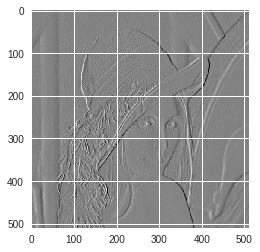

In [45]:
plt.imshow(result.data[0][0], cmap='gray')

# [補足]カラー画像入力時の注意点

## scikit-image の場合

In [0]:
from skimage.io import imread

lena_color = imread('./lena_color.png')

カラー画像は3次元配列です（縦・横・色(RGB)）

In [7]:
lena_color.shape

(512, 512, 3)

In [8]:
lena_color

array([[[222, 133, 121],
        [222, 133, 121],
        [226, 137, 129],
        ...,
        [226, 145, 121],
        [218, 121, 105],
        [198,  93,  89]],

       [[222, 133, 121],
        [222, 133, 121],
        [226, 137, 129],
        ...,
        [226, 145, 121],
        [218, 121, 105],
        [198,  93,  89]],

       [[222, 133, 121],
        [222, 133, 121],
        [226, 137, 129],
        ...,
        [226, 145, 121],
        [218, 121, 105],
        [198,  93,  89]],

       ...,

       [[ 80,  16,  56],
        [ 80,  16,  56],
        [ 89,  20,  52],
        ...,
        [170,  64,  80],
        [174,  64,  72],
        [170,  56,  72]],

       [[ 80,  16,  56],
        [ 80,  16,  56],
        [ 93,  24,  64],
        ...,
        [178,  68,  76],
        [178,  68,  76],
        [182,  68,  76]],

       [[ 80,  16,  56],
        [ 80,  16,  56],
        [ 93,  24,  64],
        ...,
        [178,  68,  76],
        [178,  68,  76],
        [182,  68,  76]]

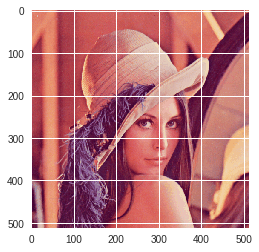

In [9]:
plt.imshow(lena_color)

## OpenCVの場合

In [0]:
# Install
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [0]:
import cv2

In [0]:
lena_color_opencv = cv2.imread('./lena_color.png')

In [0]:
lena_color_opencv

TypeError: ignored

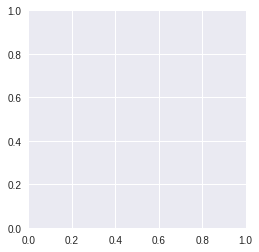

In [52]:
plt.imshow(lena_color_opencv)

ライブラリによって色チャネルの順番が違うので、注意。
- scikit-image, matplotlib: RGB
- OpenCV: BGR

"RGB"で学習されたモデルに"BGR"で読み込まれた画像を入力しても、正しい結果は得られません

In [0]:
# OpenCVで読み込んだBGR画像をRGBに変換
lena_color_opencv_rgb = lena_color_opencv[:, :, ::-1]  # x, yのチャネルはそのまま、色チャネルのみ順序を反転

plt.imshow(lena_color_opencv_rgb)